# Data analysis: Velib
## Projet

Author: O. Roustant, INSA Toulouse. January 2021.


We consider the ‘Vélib’ data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). The aim is to detect clusters in the data, corresponding to common customer usages. This clustering should then be used to predict the loading profile.

In [7]:
rm(list = ls())   # erase everything, start from scratch!
# load the data from package funFEM
library(funFEM)
data(velib)
help("velib")

In [13]:
# data preparation
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names

n <- nrow(x)
stations <- 1:n 
coord <- velib$position[stations,]

# select exactly 7 days of data (we remove the first 13 dates)
dates <- 14:181
x <- x[stations, dates]
colnames(x) <- 1:length(dates)

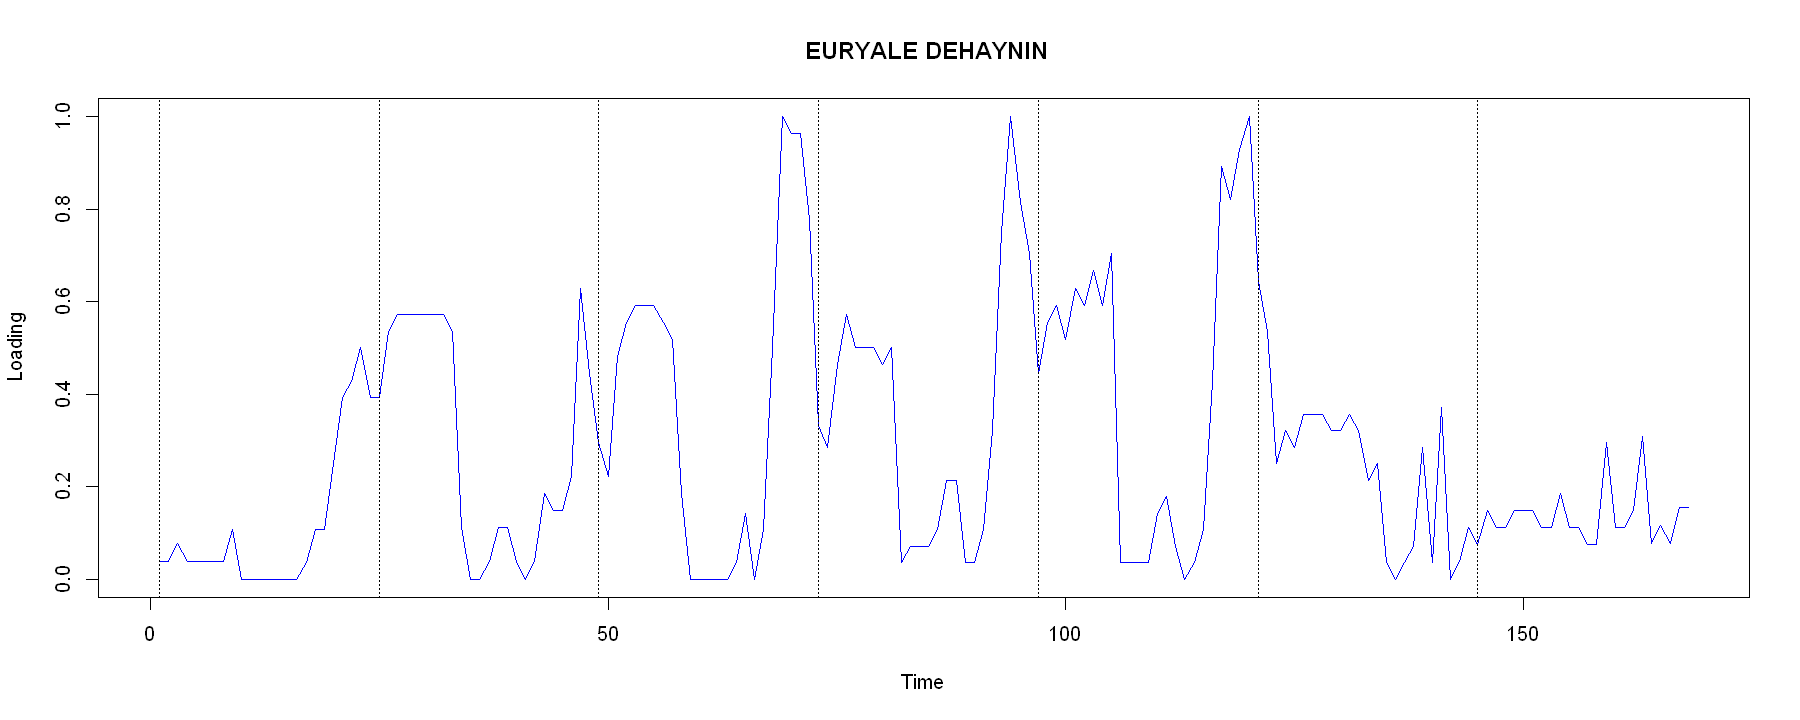

In [14]:
timeTick <- 1 + 24*(0:6)  # vector corresponding to the beginning of days
par(mfrow = c(1, 1))

options(repr.plot.width = 15, repr.plot.height = 6)

plot(x[1, ], col = "blue", type = "l", ylim = c(0, 1), 
     xlab = "Time", ylab = "Loading", main = rownames(x)[1])
abline(v = timeTick, lty = "dotted")


Commentaires:
On a ici une représentation du ratio nombre de vélos disponibles sur le nombre de vélos total pour la première station EURYALE DEHAYNIN en fonction des heures de la semaine. Les droites en pointillé permettent de distinguer les différents jours de la semaine. Pour cette station, on observe différents schémas d'occupation selon le moment de la semaine (week end, lundi-mardi, mer-jeu-ven). Le week-end, l'utilisation des vélos est beaucoup plus élevé et plus stable (moins de variabilité).


In [12]:
# From now on, we use numbers instead of station names, 
# in order to simplify printing
#rownames(x) <- 1:nrow(x)

# Descriptive statistics.

1. Draw a matrix of plots of size 4*4, corresponding to the first 16 stations. (Do not forget the vertical lines corresponding to days).

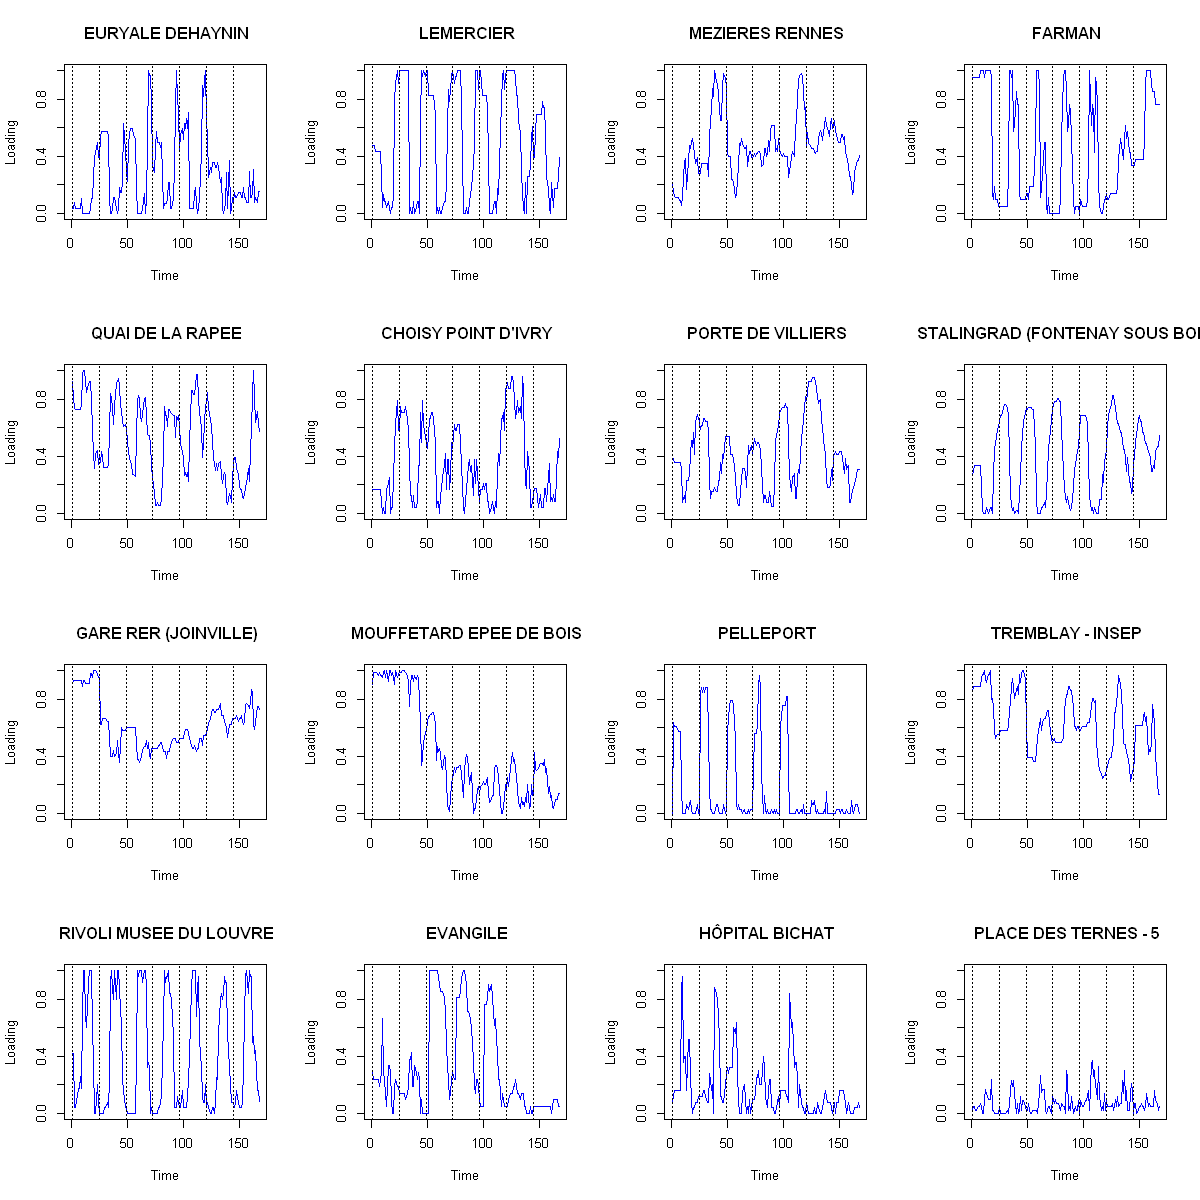

In [18]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(4,4))
for (i in 1:16)
{
    
    plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1), 
         xlab = "Time", ylab = "Loading", main = velib$names[i])
    abline(v = timeTick, lty = "dotted")
}

Commentaires:
L'occupation des vélos différe selon les stations même si on peut retrouver des comportements proches entre certains groupes de stations. Certaines ont un rythme d'utlisation régulier tout au long de la semaine (stations du louvre, place des ternes) : pas de différence entre jours ouvrés et week end. 
La station place des ternes a un taux d'utilisation particulièrement élevé. 
Pour certaines stations comme PEELLEPORT ou LA GARE RER, la différence entre jours ouvrés et week end est plus marquée. 
Selon la station observé, les vélos seront plutôt utilisés en jour ou en soirée. 

2. Draw the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?

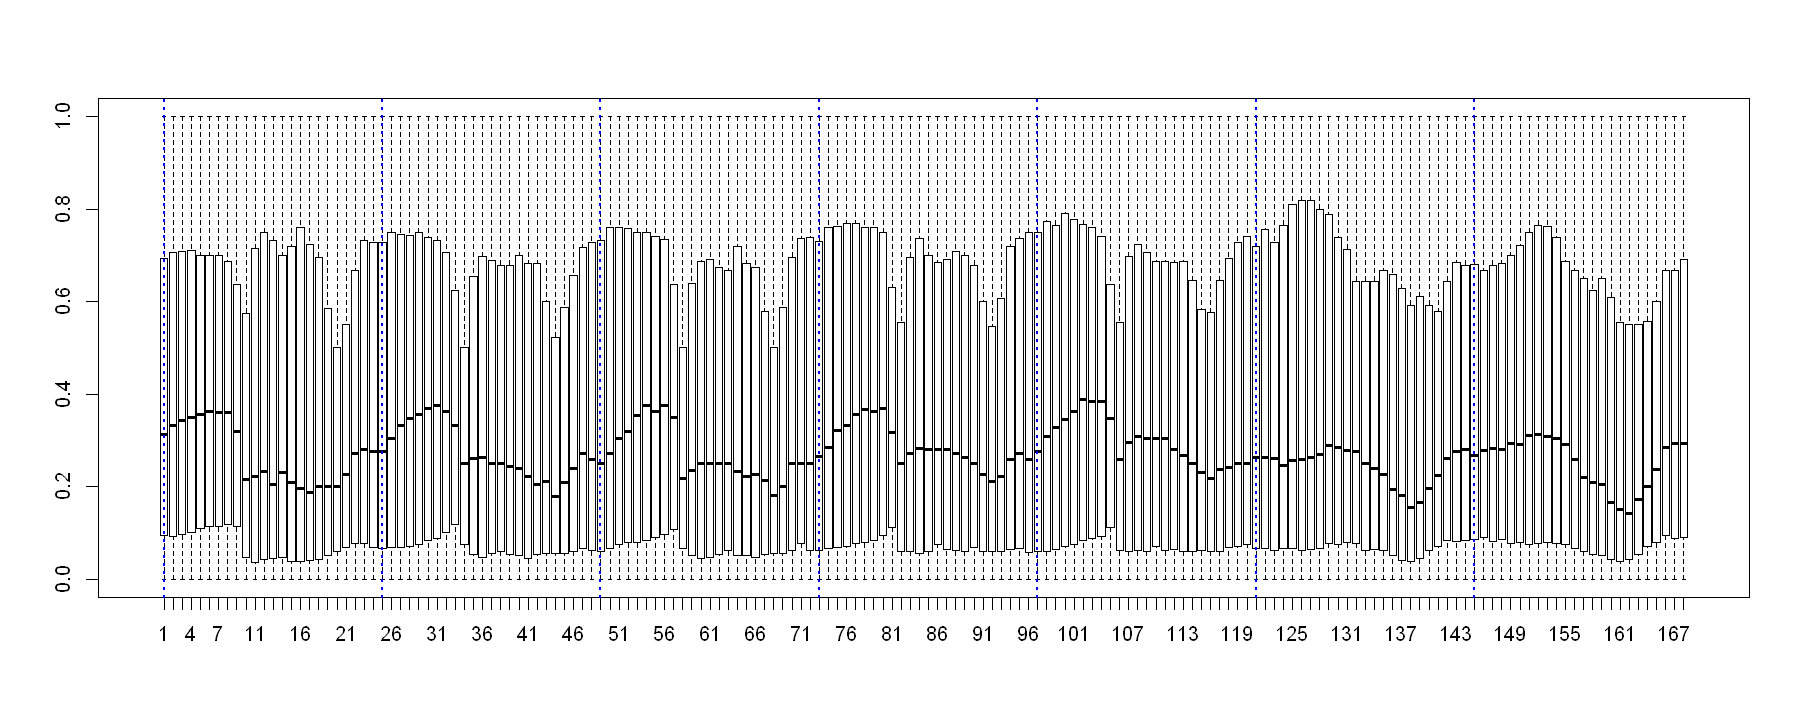

In [20]:
options(repr.plot.width = 15, repr.plot.height = 6)
boxplot(x[ , 1:ncol(x)])  # ou boxplot(x)
abline(v = timeTick, lty = "dotted", col = "blue", lwd = 2)

Commentaires:

Le boxplot de toutes les variables montrent que la médiane a une composante saisonnière pour les cinq premiers jours de la semaine: variation cyclique de jour en jour. Dans un jour, on a deux tendances, une croissance pendant la nuit et une décrue en  journée.

Pour ce qui est de la dispersion, on a à peu près la même échelle pour toutes les variables donc inutile de réduire les données, écart interquartile grand donc une grande dispersion entre les stations

position->médiane
dispersion-> largeur
symétrie-> ecart entre médiane et troisième quartile pareil que écart entre médiane et premier quartile?

Réponse: médiane plus proche de 0 que de 1 dans l'ensemble (dissymétrie), périodicité à la journée pour les cinq premiers jours qui est pareile et aussi pour le week end mais une périodicité différente. 
Pour les clusters, penser à la différence semaine/week end et jour/nuit.
La disymétrie est saisonnière, plus symétrique à la nuit qu'au jour et asymétrie plus marquée au week end.

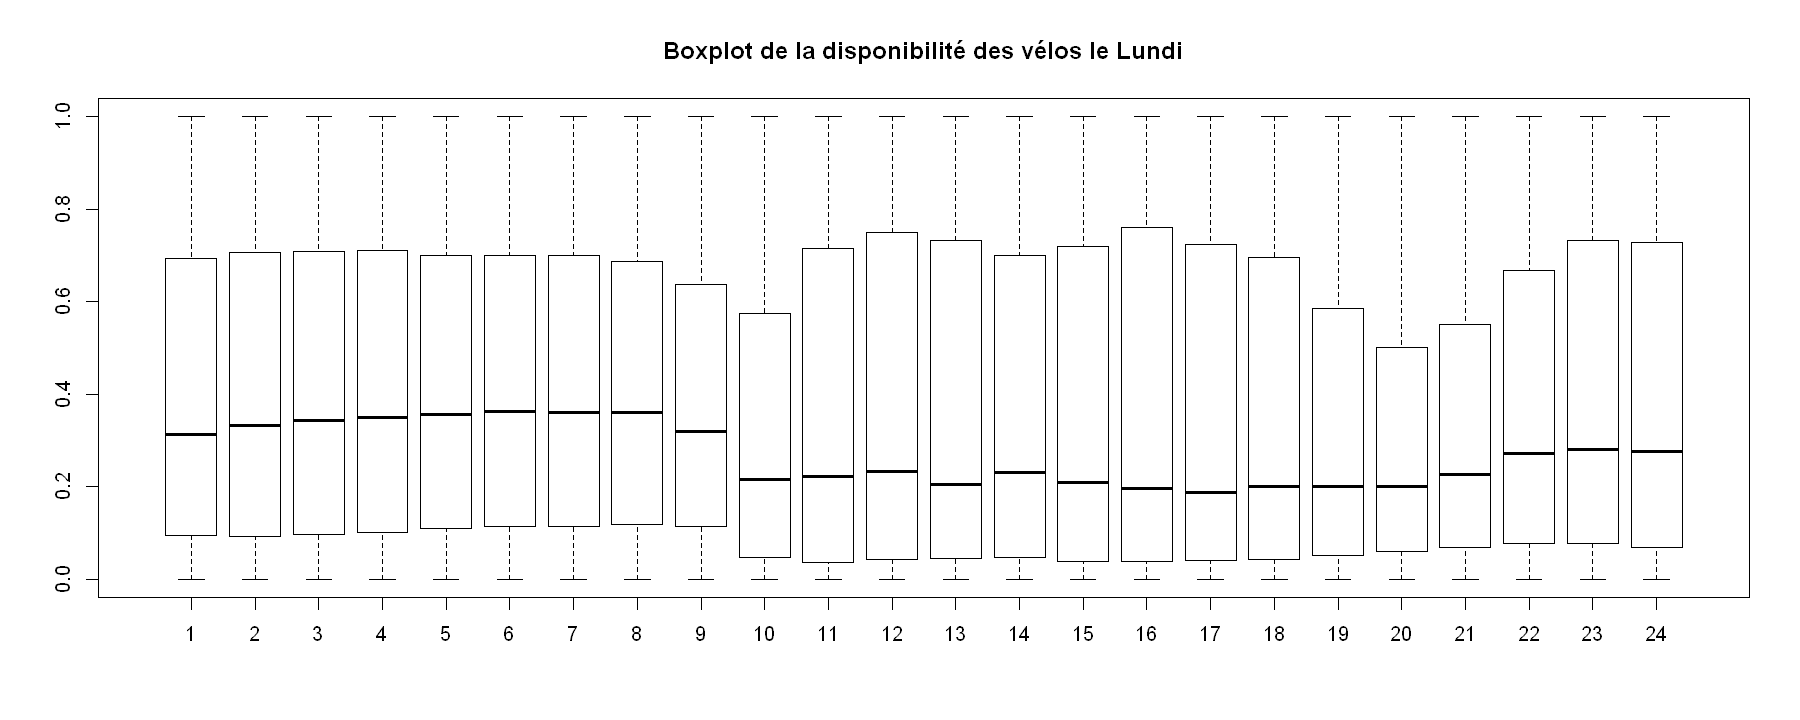

In [21]:
#boxplot pour les premières 24 heures
options(repr.plot.width = 15, repr.plot.height = 6)
boxplot(x[, 1:24],main="Boxplot de la disponibilité des vélos le Lundi")

Commentaires:

L'évolution de la médiane indique que, pour le Lundi, l'utilisation est en moyenne plus importante entre 10h et 20h et plus faible la nuit entre 22h et 09h.

3. Investigate the temporal correlation of the variables. 
For instance, for a given station, plot the loading at t+h versus loading at time t.
Visualize the correlation matrix by an image plot. Interpret the result.

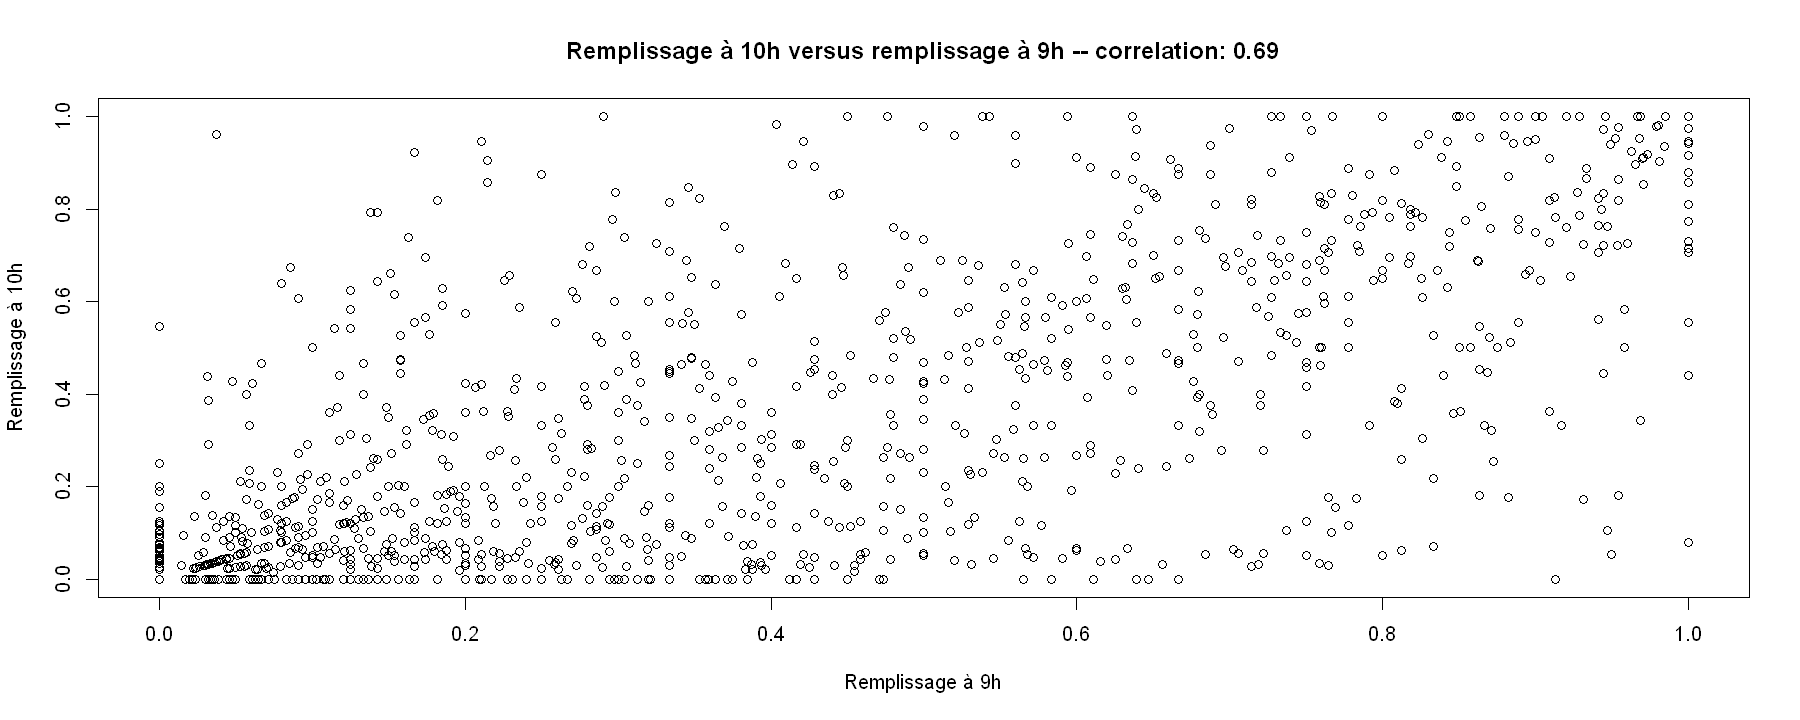

In [8]:
# Question 3
t <- 9
h <- 1
mycor <- round(cor(x[, t], x[, t+h]), 2)
plot(x[, t], x[, t+h], main = paste("Remplissage à ", t+h, 
        "h versus remplissage à ", t, "h -- correlation: ", 
                                    mycor, sep = ""), 
    xlab = paste("Remplissage à ", t, "h", sep = ""),
    ylab = paste("Remplissage à ", t+h, "h", sep = ""))

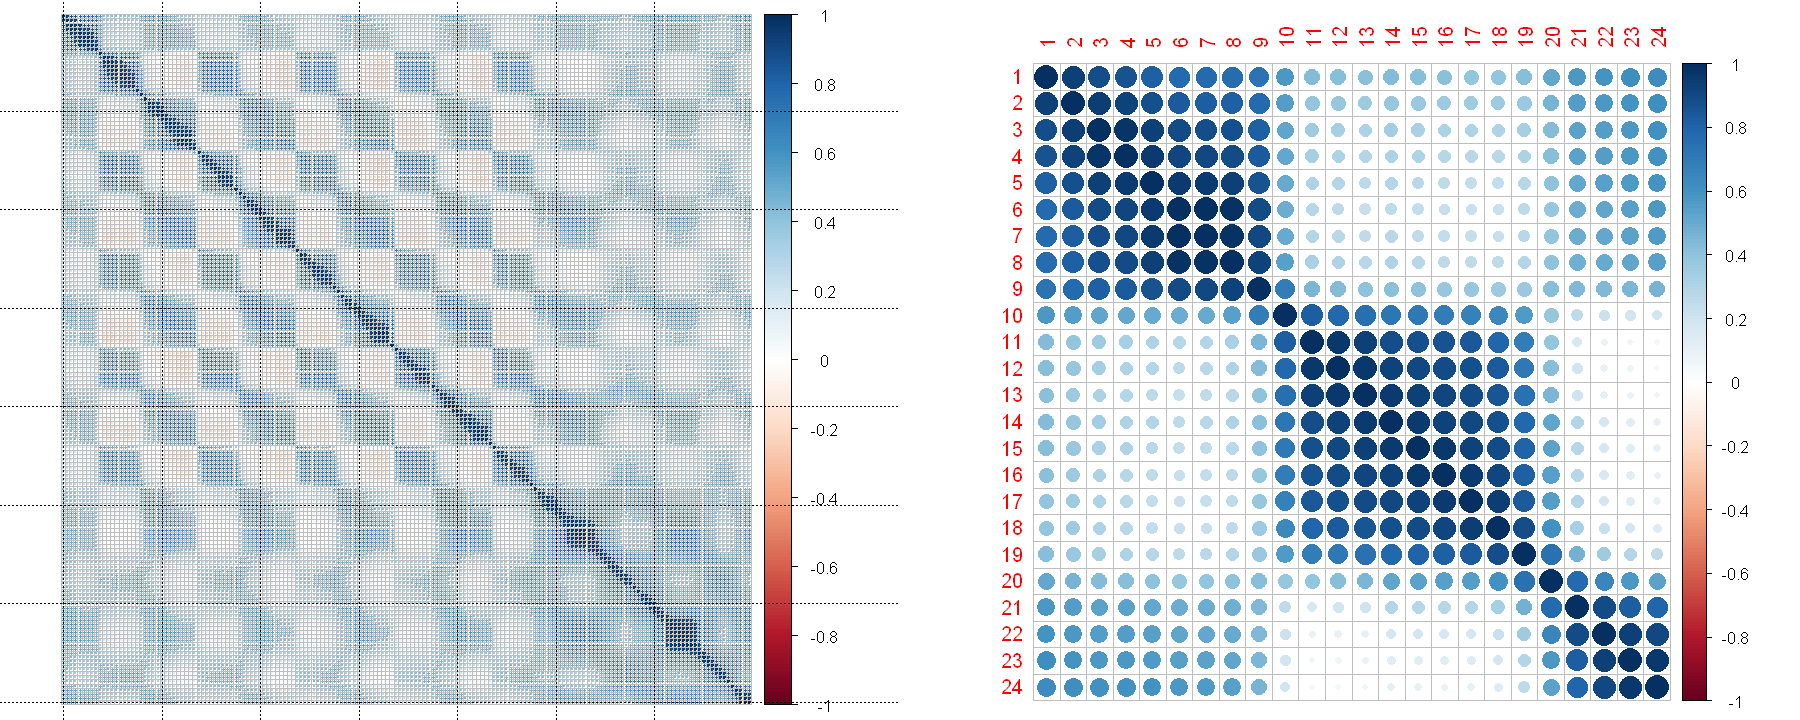

In [10]:
library(corrplot)
cormat <- cor(x) 
par(mfrow = c(1, 2))
corrplot(cormat, tl.pos = "n")
abline(v = timeTick, h = timeTick, col = "black", lty = "dotted")
corrplot(cormat[1:24, 1:24])


Some ideas : 

1. Draw a matrix of plots of size 4*4, corresponding to the first 16 stations. (Do not forget the vertical lines corresponding to days).
2. Draw the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?
3. Investigate the temporal correlation of the variables. 
For instance, for a given station, plot the loading at t+h versus loading at time t.
Visualize the correlation matrix by an image plot. Interpret the result.
4. Plot the stations coordinates on a 2D map (latitude versus longitude). Use a different color for stations which are located on a hill.
5. Redo questions 1-3 for the subset of stations which are located on a hill. Same questions for those who are not. Comment?

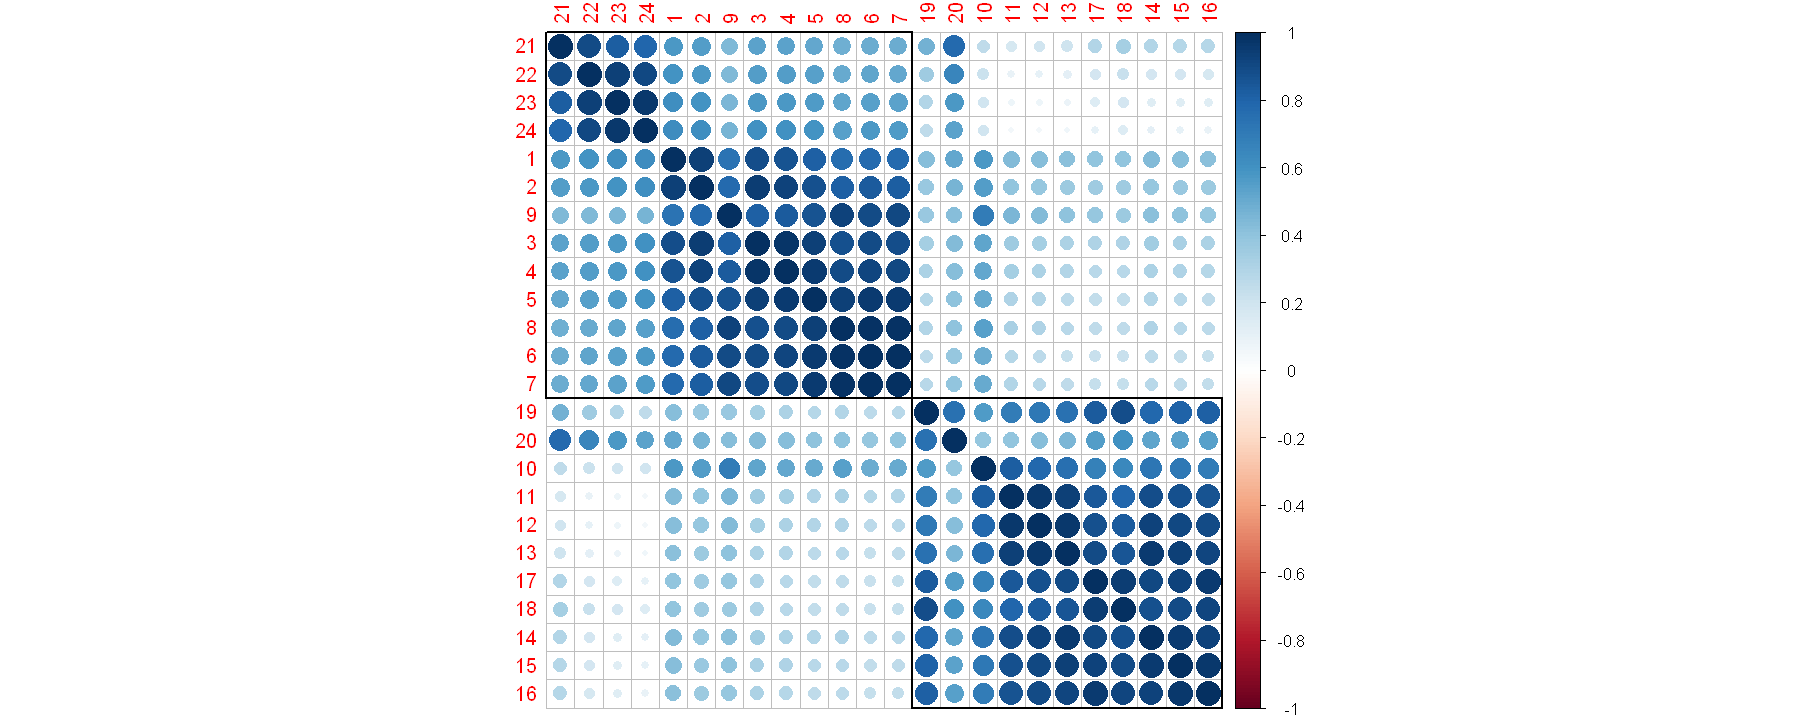

In [11]:
# Pour trouver des clusters dans la matrice de correlation
par(mfrow = c(1, 1))
corrplot(cormat[1:24, 1:24], order = "hclust", addrect = 2)
help(corrplot)

[1] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0

[1] "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue"
[11] "red"  "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue" "blue"

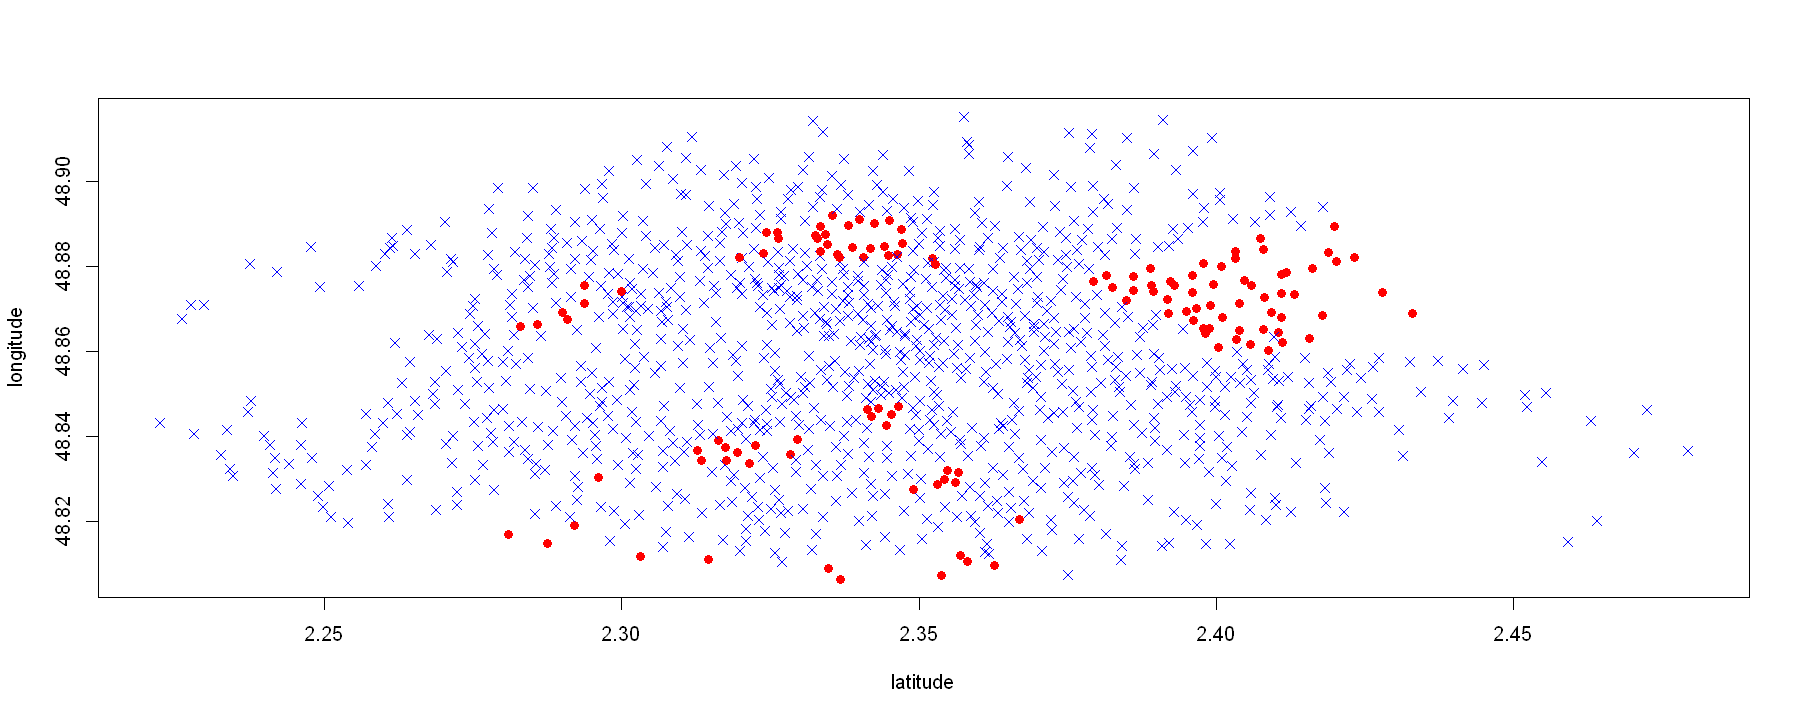

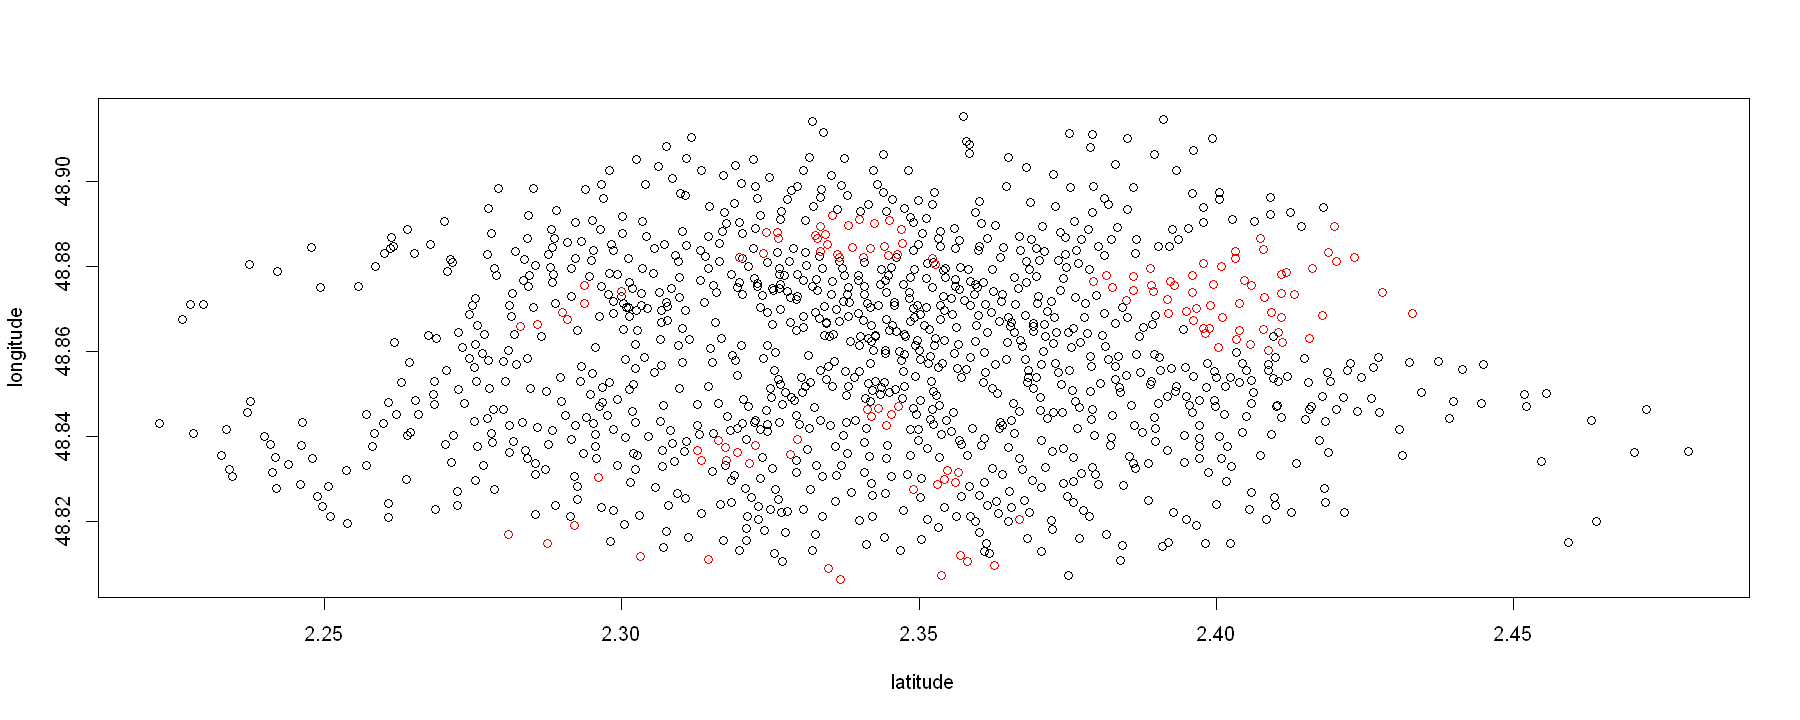

In [12]:
# Question 4

velib$bonus[1:20]
ifelse(velib$bonus[1:20] == 1, "red", "blue")

plot(velib$position$longitude, velib$position$latitude, 
     col = ifelse(velib$bonus == 1, "red", "blue"),
     xlab = "latitude", ylab = "longitude", 
     pch = ifelse(velib$bonus == 1, 19, 4))

plot(velib$position$longitude, velib$position$latitude, 
     col = velib$bonus + 1,
     xlab = "latitude", ylab = "longitude")


[1]   11   36   46   59   85   89   91  102  106  114  138  140  152  153  188
 [16]  191  204  224  233  247  257  275  302  303  307  326  327  328  329  346
 [31]  348  359  362  384  385  386  394  397  419  422  427  429  436  437  440
 [46]  442  446  450  457  461  463  473  479  480  489  504  518  520  523  524
 [61]  528  554  555  556  595  598  601  604  614  617  618  644  645  651  667
 [76]  669  675  692  713  717  724  726  734  755  762  765  770  806  828  865
 [91]  872  881  905  912  921  930  933  934  940  942  953  957  975  980  982
[106]  991  995  997 1001 1008 1028 1029 1068 1072 1076 1077 1088 1091 1093 1102
[121] 1109 1124 1133 1147 1153 1169 1187

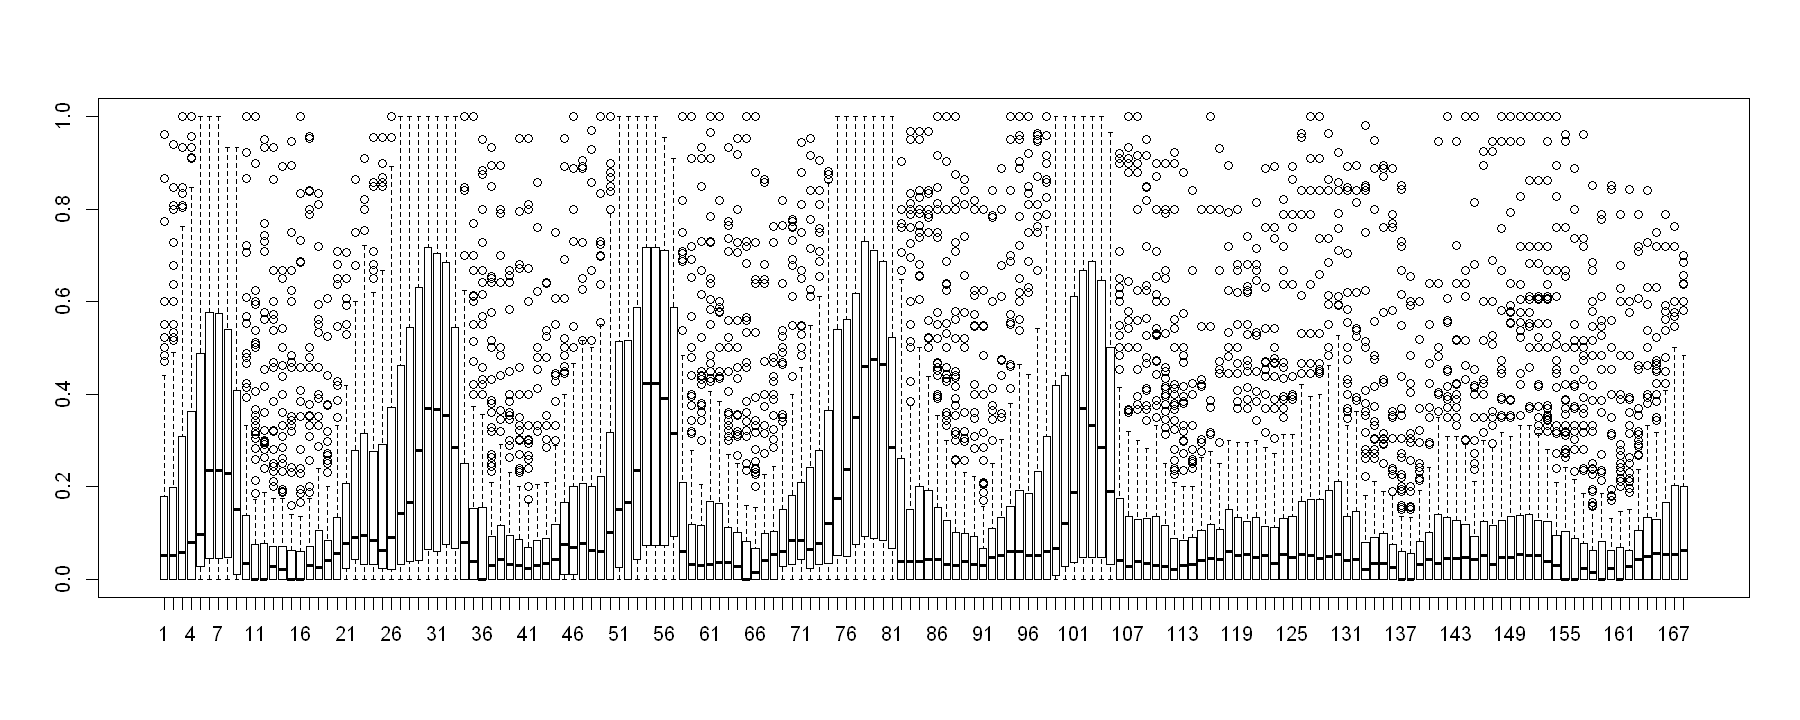

In [13]:
# Question 5
stationHill <- which(velib$bonus == 1)
stationHill
boxplot(x[stationHill, ])

In [15]:
library("FactoMineR")
library("factoextra")

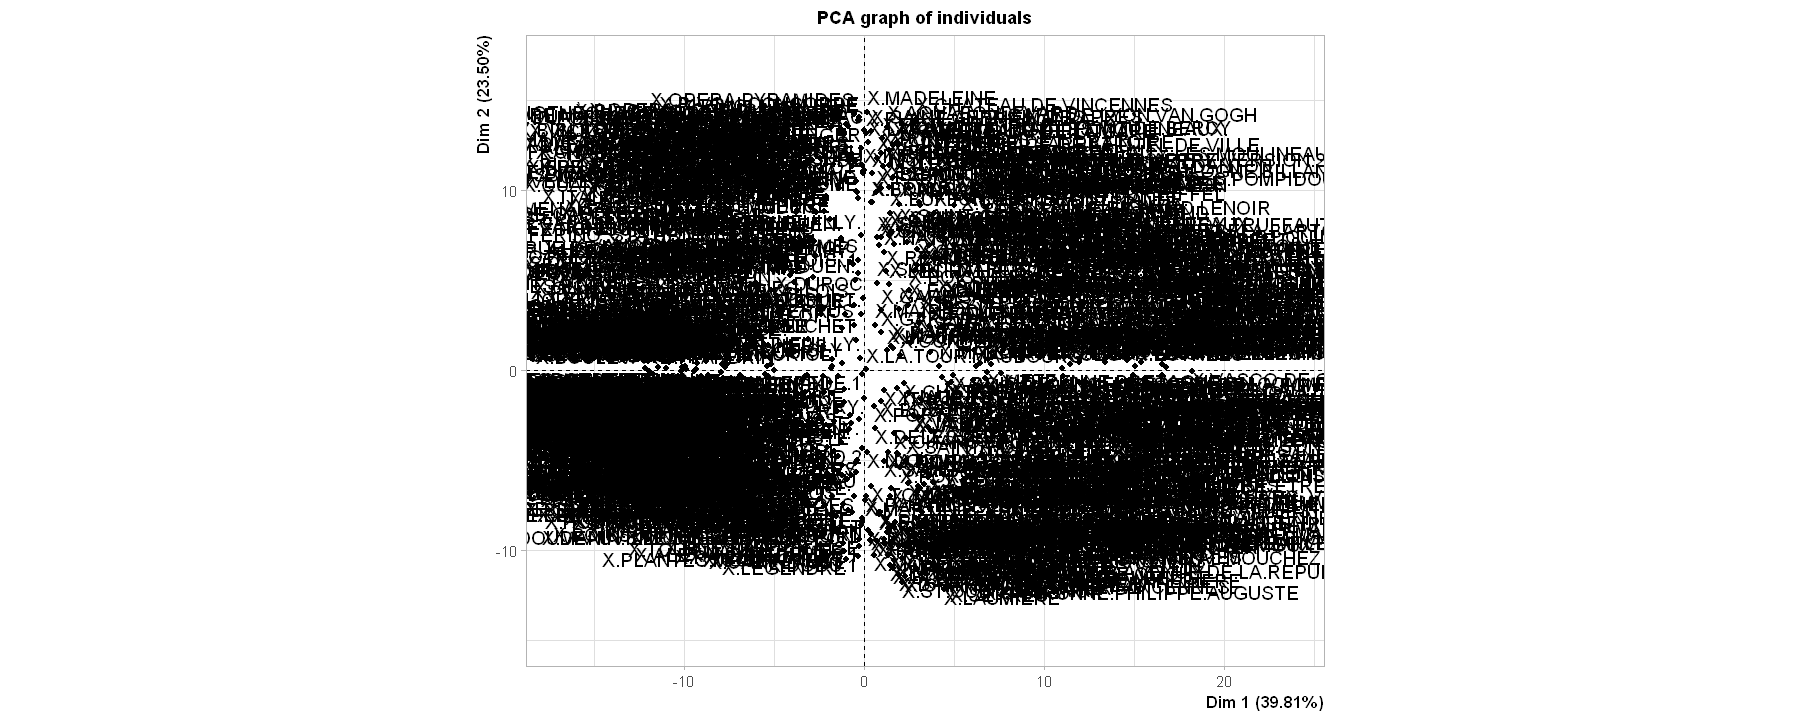

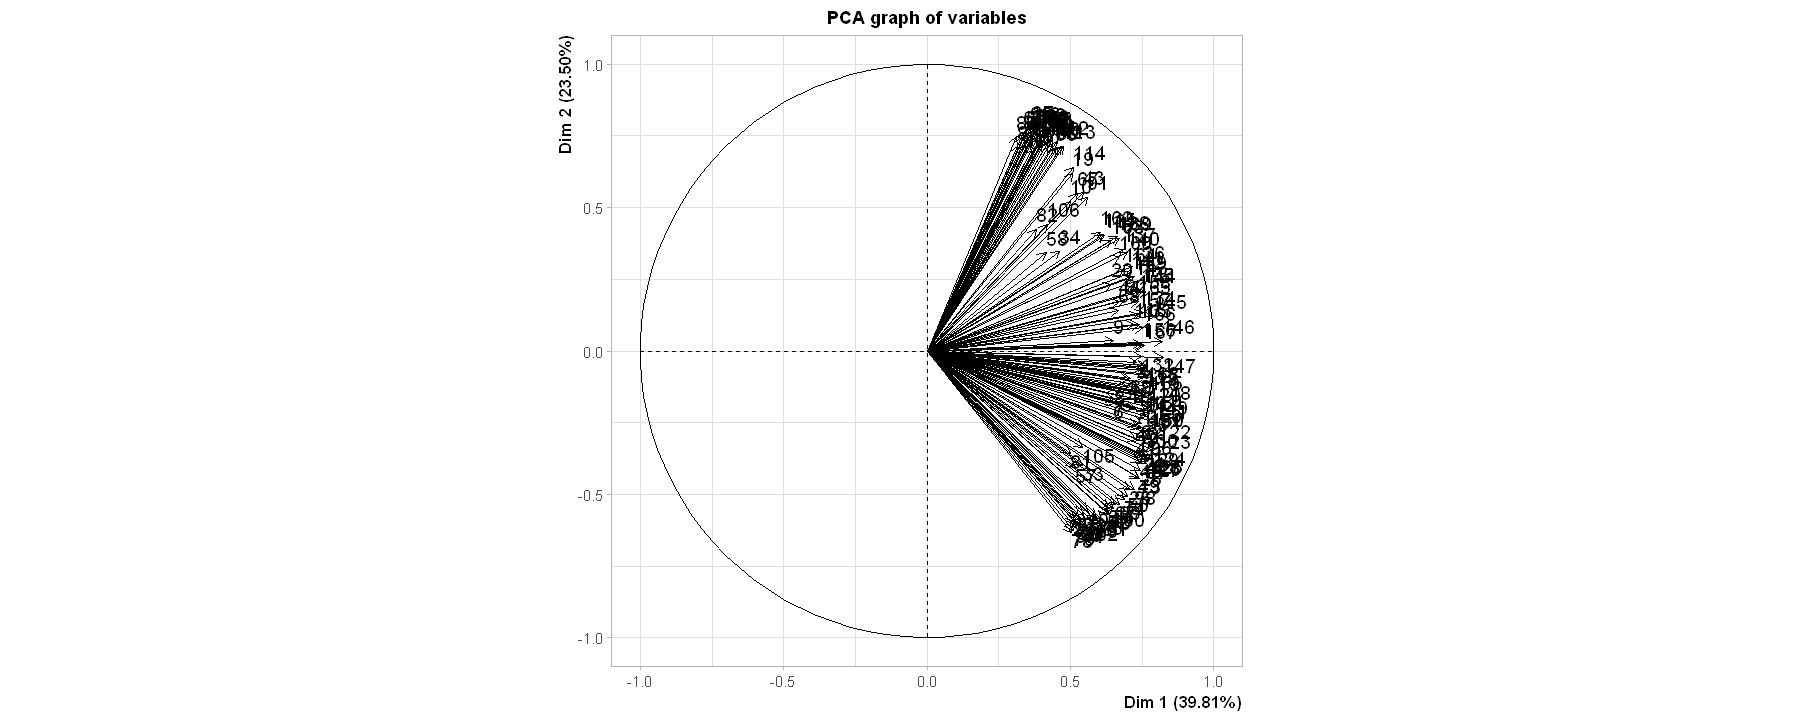

In [16]:
velib.pca=PCA(x,scale=TRUE)